# Multilayer Perceptron para a previsão de dados de precipitação

Aplicar também PCA?

Mensurar tempo de treino dos modelos

## Importação dos dados

In [ ]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import glob
from sklearn.decomposition import PCA

import time as t
import pickle

In [16]:
df = pd.read_csv("Banco de dados/inmet_filtrado_mirante.csv", index_col=0)

## Limpeza dos dados

### Normalização dos dados

A fórmula é: $\tilde{x_i} = \dfrac{x_{i} - \overline{x}}{\sigma}$

In [17]:
df.mean()

PRECIPITACAO TOTAL, HORARIO(mm)                     0.181972
TEMPERATURA DO PONTO DE ORVALHO(°C)                14.126436
TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT)(°C)    14.627583
TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT)(°C)    13.652489
UMIDADE REL. MAX. NA HORA ANT. (AUT)(%)            71.875480
UMIDADE RELATIVA DO AR, HORARIA(%)                 69.346008
VENTO, RAJADA MAXIMA(m/s)                           5.225672
dtype: float64

In [18]:
df_norm = (df - df.mean())/df.std()
df_norm["PRECIPITACAO TOTAL, HORARIO(mm)"] = df["PRECIPITACAO TOTAL, HORARIO(mm)"]

In [19]:
df_norm.head(2)

,"PRECIPITACAO TOTAL, HORARIO(mm)",TEMPERATURA DO PONTO DE ORVALHO(°C),TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT)(°C),TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT)(°C),UMIDADE REL. MAX. NA HORA ANT. (AUT)(%),"UMIDADE RELATIVA DO AR, HORARIA(%)","VENTO, RAJADA MAXIMA(m/s)"
Data,,,,,,,
2010-10-10 00:00:00,0.0,-0.711163,-0.867264,-0.673133,0.902522,0.995876,0.757262
2010-10-10 01:00:00,0.0,-0.738240,-0.839535,-0.620390,0.902522,0.826644,0.373708


### Simplificação e separação dos dados

In [20]:
filtrar_ = lambda value: int(value > 0)

In [21]:
features = df_norm.columns[1:]

In [22]:
X = df_norm[features]
Y = df_norm['PRECIPITACAO TOTAL, HORARIO(mm)']
Y = Y.apply(filtrar_)

## Separação dos dados

In [23]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

## Criação do modelo

In [27]:
model = Sequential([
    Input(shape=(len(features),)), # Camada de Input
    Dense(4, activation="sigmoid"), # Camada oculta
    Dense(1, activation="sigmoid") # Camada de Output
])
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 4)              │            28 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33 (132.00 B)

 Trainable params: 33 (132.00 B)

 Non-trainable params: 0 (0.00 B)

O optimezer poderia ser uma string, no entanto, para brevidade nas explicações do relatório foi utlizado uma instância mesmo

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model.compile(optimizer=tf.optimizers.Adam(),
              loss='binary_crossentropy',
              metrics=['accuracy'])

## Treino e resultados

In [ ]:
# Pula o treino se já houve um modelo salvo
if not glob.glob("mlp.keras"):
    t_i = t.time()
    mod = model.fit(x_train, y_train, epochs=100, batch_size=100, validation_data=(x_test, y_test), callbacks=[early_stopping])
    t_f = t.time()
    print("Tempo de execução: ", t_f - t_i)
    # Salvar o modelo e a history
    model.save("mlp.keras")
    with open("mlp_history.pkl", "wb") as f:
        pickle.dump(mod.history, f)
else:
    print("Modelo já treinado!")
    # Carregar o modelo e a history
    model = load_model("mlp.keras")
    with open("mlp_history.pkl", "rb") as f:
        mod = pickle.load(f)

Epoch 1/100
1026/1026 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.9203 - loss: 0.2949 - val_accuracy: 0.9198 - val_loss: 0.2193
Epoch 2/100
1026/1026 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9219 - loss: 0.2081 - val_accuracy: 0.9198 - val_loss: 0.1966
Epoch 3/100
1026/1026 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.9219 - loss: 0.1914 - val_accuracy: 0.9234 - val_loss: 0.1874
Epoch 4/100
1026/1026 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.9256 - loss: 0.1833 - val_accuracy: 0.9264 - val_loss: 0.1831
Epoch 5/100
1026/1026 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.9291 - loss: 0.1815 - val_accuracy: 0.9277 - val_loss: 0.1806
Epoch 6/100
1026/1026 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9305 - loss: 0.1800 - val_accuracy: 0.9289 - val_loss: 0.1789
Epoch 7/100
1026/1026 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9318 - loss: 0.1786 - val_accuracy: 0.9290 - val_loss: 0.1778
Epoch 8/100
1026/1026 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9316 - loss: 0

AttributeError: 'History' object has no attribute 'save'

## Teste do modelo

In [38]:
results = model.evaluate(x_test, y_test, verbose=1)
print(f'Loss: {results[0]} - Acurácia: {results[1]}')

802/802 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9334 - loss: 0.1634
Loss: 0.16389307379722595 - Acurácia: 0.9342485070228577


### Visualização dos dados

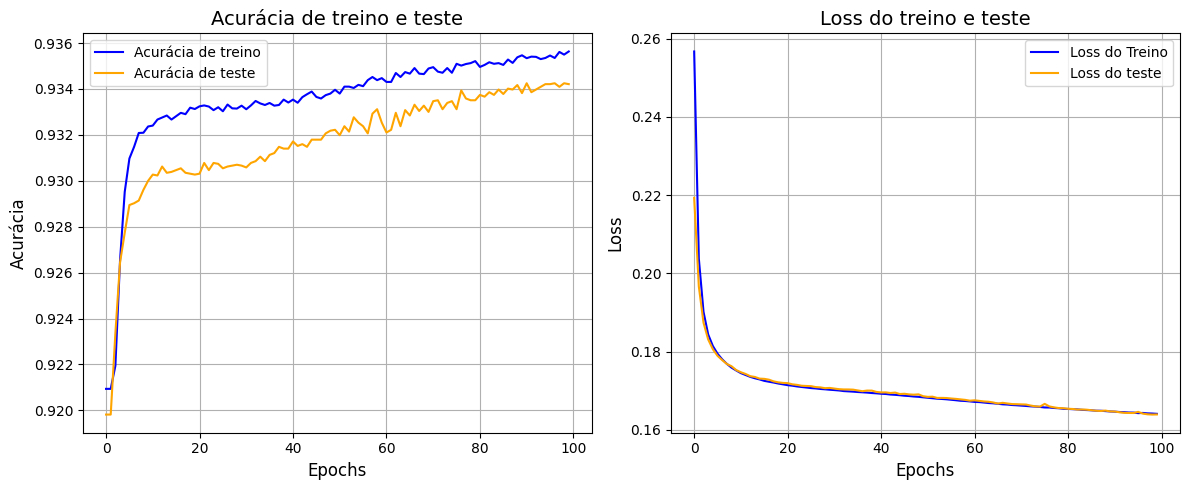

In [42]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(mod.history['accuracy'], label='Acurácia de treino', color='blue')
plt.plot(mod.history['val_accuracy'], label='Acurácia de teste', color='orange')
plt.title('Acurácia de treino e teste', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Acurácia', fontsize=12)
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(mod.history['loss'], label='Loss do Treino', color='blue')
plt.plot(mod.history['val_loss'], label='Loss do teste', color='orange')
plt.title('Loss do treino e teste', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend()
plt.grid(True)

# plt.suptitle("Model Training Performance", fontsize=16)
plt.tight_layout()
plt.show()

### Matriz de confusão

In [ ]:
y_pred = model.predict(x_test)
y_pred = y_pred.flatten()

802/802 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step


In [99]:
y_pred_dicot = pd.Series(y_pred, y_test.index)
y_pred_dicot = (y_pred > 0.5).astype(int)

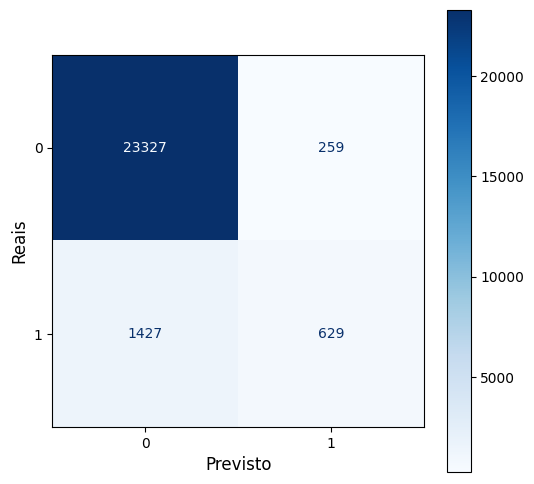

In [111]:
cm = confusion_matrix(y_test, y_pred_dicot)
cm_disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
fig, ax = plt.subplots(figsize=(6, 6))
cm_disp.plot(ax=ax, cmap='Blues', values_format='d')
ax.set_xlabel('Previsto', fontsize=12)
ax.set_ylabel('Reais', fontsize=12)
plt.show()

Confirmação dos valores da matriz de ocnfusão

In [106]:
print("Acurácia total:", (23327 + 629)/len(y_pred_dicot))

Acurácia total: 0.9342484985570548


## Weight e Bias

### Camada oculta

In [113]:
weights, biases = model.layers[0].get_weights()

Note que está transposto!

In [114]:
weights.shape

(6, 4)

1 bias por neurônio

In [115]:
biases.shape

(4,)

Formato em LaTex:

\begin{bmatrix}
1 & 2 & 3\\
a & b & c
\end{bmatrix}

In [120]:
weights.T

array([[ 0.97634286, -1.9522462 ,  0.34698686, -2.7568676 , -0.6865847 ,
        -0.16645359],
       [-1.433105  , -2.2095802 ,  4.080188  , -0.6881494 , -1.051062  ,
        -0.31405678],
       [-1.908303  , -2.7503285 ,  4.137449  ,  1.6544156 , -0.8605119 ,
        -0.34463218],
       [-1.1312401 ,  1.5943722 , -0.7186267 , -0.0605193 ,  2.9796646 ,
         0.07091773]], dtype=float32)

Pesos

In [ ]:
print("\\begin{bmatrix}")
for linha in weights.T:
    linha_str = [str(el) for el in linha]
    print(" & ".join(linha_str), end=" ")
    print("\\\\")
print("\\end{bmatrix}")

\begin{bmatrix}
0.97634286 & -1.9522462 & 0.34698686 & -2.7568676 & -0.6865847 & -0.16645359 \\
-1.433105 & -2.2095802 & 4.080188 & -0.6881494 & -1.051062 & -0.31405678 \\
-1.908303 & -2.7503285 & 4.137449 & 1.6544156 & -0.8605119 & -0.34463218 \\
-1.1312401 & 1.5943722 & -0.7186267 & -0.0605193 & 2.9796646 & 0.070917726 \\
\end{bmatrix}


Biases

In [131]:
print("\\begin{bmatrix}")
linha_str = [str(el) for el in biases.T]
print("\\\\\n".join(linha_str))
print("\\end{bmatrix}")

\begin{bmatrix}
1.531187\\
0.24852464\\
-0.39425907\\
-2.6061049
\end{bmatrix}


### Camada de Output

In [132]:
weights, biases = model.layers[1].get_weights()

In [133]:
weights.shape

(4, 1)

In [134]:
biases.shape

(1,)

Pesos

In [138]:
print("\\begin{bmatrix}")
linha_str = [str(el) for el in weights.T.flatten()]
print("\\\\\n".join(linha_str))
print("\\end{bmatrix}")

\begin{bmatrix}
-3.4306805\\
-3.2021632\\
-4.5189514\\
3.771724
\end{bmatrix}


Biases

In [136]:
print("\\begin{bmatrix}")
linha_str = [str(el) for el in biases.T]
print("\\\\\n".join(linha_str))
print("\\end{bmatrix}")

\begin{bmatrix}
0.87639076
\end{bmatrix}


## Treino com o PCA

In [ ]:
pca = PCA()

In [ ]:
df_proj = pca.fit_transform(df_norm.drop("PRECIPITACAO TOTAL, HORARIO(mm)", axis=1))
df_proj = pd.DataFrame(df_proj, columns=pca.get_feature_names_out())

In [ ]:
df_proj = df_proj.drop(["pca2", "pca3", "pca4", "pca5"], axis=1)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(df_proj, Y, test_size=0.2, random_state=42)

In [ ]:
model = Sequential([
    Input(shape=(2,)), # Camada de Input
    Dense(12, activation="sigmoid"), # Camada oculta
    Dense(1, activation="sigmoid") # Camada de Output
])
model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_16 (Dense)                │ (None, 12)             │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │            13 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 49 (196.00 B)

 Trainable params: 49 (196.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
t_i = t.time()
mod = model.fit(x_train, y_train, epochs=100, batch_size=100, validation_data=(x_test, y_test), callbacks=[early_stopping])
t_f = t.time()
print("Tempo de execução: ", t_f - t_i)


Epoch 1/100
1026/1026 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9156 - loss: 0.3524 - val_accuracy: 0.9198 - val_loss: 0.2309
Epoch 2/100
1026/1026 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9222 - loss: 0.2250 - val_accuracy: 0.9198 - val_loss: 0.2271
Epoch 3/100
1026/1026 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9198 - loss: 0.2282 - val_accuracy: 0.9198 - val_loss: 0.2265
Epoch 4/100
1026/1026 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9217 - loss: 0.2232 - val_accuracy: 0.9198 - val_loss: 0.2265
Epoch 5/100
1026/1026 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9213 - loss: 0.2229 - val_accuracy: 0.9198 - val_loss: 0.2270
Epoch 6/100
1026/1026 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9208 - loss: 0.2257 - val_accuracy: 0.9198 - val_loss: 0.2265
Epoch 7/100
1026/1026 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9217 - loss: 0.2242 - val_accuracy: 0.9198 - val_loss: 0.2266
Epoch 8/100
1026/1026 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9206 - loss: 0

In [ ]:
results = model.evaluate(x_test, y_test, verbose=0)
print('Loss, Acurácia:', results)

Loss, Acurácia: [0.222764253616333, 0.9201700091362]


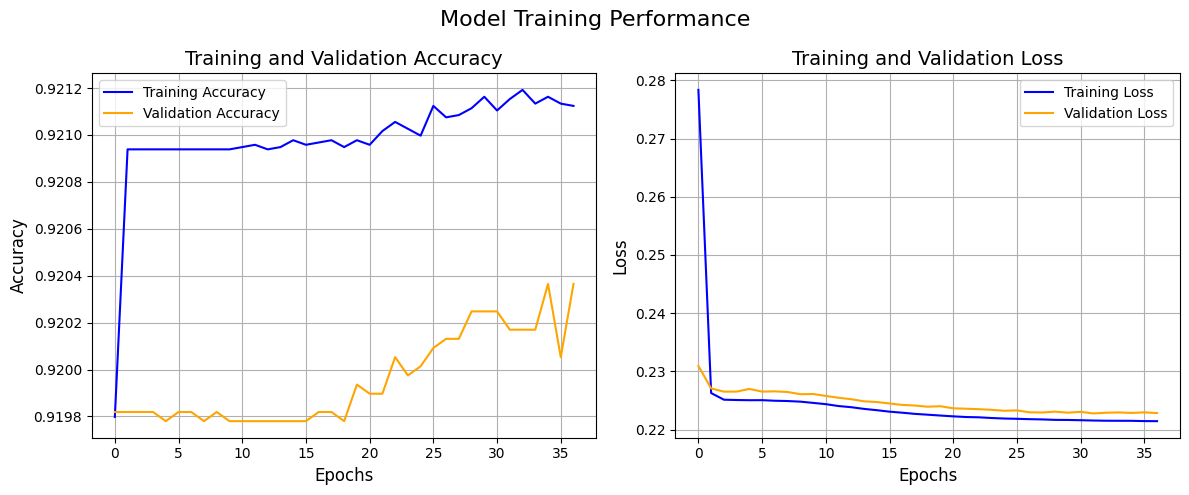

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(mod.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(mod.history['val_accuracy'], label='Validation Accuracy', color='orange')
plt.title('Training and Validation Accuracy', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(mod.history['loss'], label='Training Loss', color='blue')
plt.plot(mod.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Training and Validation Loss', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend()
plt.grid(True)

plt.suptitle("Model Training Performance", fontsize=16)
plt.tight_layout()
plt.show()

## Coeficientes (*Weights* e *biases*)

### Layer 0 - Input

In [ ]:
weights, biases = model.layers[0].get_weights()

In [ ]:
weights

array([[-0.5486462 ,  0.55288535, -0.61635697, -0.5722085 , -0.48489484,
        -0.94807124,  0.33663478,  0.44726062, -0.47462344, -0.56366694,
        -0.8046138 , -0.95327306],
       [-0.4709928 , -0.04333638, -0.26038763,  0.32512414, -2.4926202 ,
         0.65178335,  1.0601221 ,  0.07280689, -0.5385911 , -0.00902334,
         0.49744686,  0.67467225]], dtype=float32)

In [ ]:
biases

array([ 1.1025844 , -0.42639717,  0.95126367, -0.31773126, -1.5783712 ,
        0.5523678 , -1.5094568 , -0.37989002,  1.0212535 ,  0.47094798,
        0.35182557,  0.50182587], dtype=float32)

In [ ]:
weights.shape

(2, 12)

In [ ]:
biases.shape

(12,)

In [ ]:
weights, biases = model.layers[1].get_weights()

In [ ]:
weights.shape

(12, 1)

In [ ]:
biases.shape

(1,)